In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics
from matplotlib import ticker

In [2]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("max_columns", 100)

In [3]:
a_names = pd.read_csv("data/a_names.csv")

In [4]:
y = a_names['callback']
X = a_names.drop(['callback'], axis=1)

## Preprocessing Data - Asian Names Data ##

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [6]:
kfold = KFold(n_splits=5)
skfold = StratifiedKFold(n_splits=5, shuffle=True)
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

In [7]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
from sklearn.linear_model import LogisticRegression
logreg_scaled = LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear').fit(X_train_scaled, y_train)

print("PENALIZED LOGISTIC REGRESSION (SCALED DATA)")
print("Training set score: {:.2f}".format(logreg_scaled.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(logreg_scaled.score(X_test_scaled, y_test)))

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(logreg_scaled, 
                                                                             X_train_scaled, 
                                                                             y_train, 
                                                                             cv=skfold,
                                                                            scoring = 'accuracy'))))


logreg_scaled_coef = pd.DataFrame(data=logreg_scaled.coef_, 
                                  columns=X.columns, 
                                  index=['Penalized Scaled Logistic Regression Coefficients'])

yhat = logreg_scaled.predict(X_test_scaled)
c2 = [logreg_scaled_coef]
coefs = pd.concat(c2)
coefs.T.sort_values(by = 'Penalized Scaled Logistic Regression Coefficients', ascending=False)

PENALIZED LOGISTIC REGRESSION (SCALED DATA)
Training set score: 0.91
Test set score: 0.92
Mean Cross Validation, SKFold: 0.91


,Penalized Scaled Logistic Regression Coefficients
skillspeaking,0.224877
language_skills,0.118787
ma,0.073995
exp_highquality,0.038035
certificate,0.037417
female,0.035570
ba_quality,0.033053
extracurricular_skills,-0.004030
accreditation,-0.046706
reference,-0.069764


<AxesSubplot:title={'center':'Feature Importance (Logistic Regression)'}>

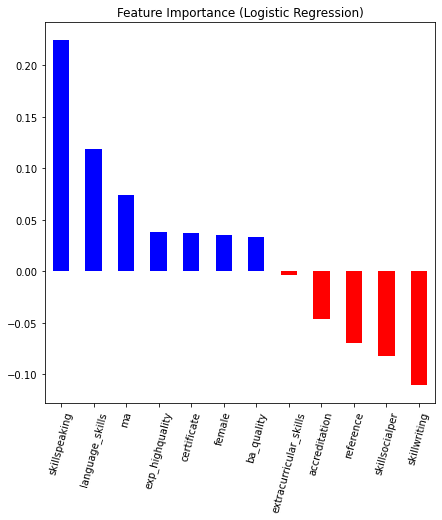

In [9]:
graph = coefs.T.sort_values(by = 'Penalized Scaled Logistic Regression Coefficients', ascending=False)
graph['Penalized Scaled Logistic Regression Coefficients'].plot.bar(
    title = 'Feature Importance (Logistic Regression)',
    legend = False, 
    figsize = (7,7),
    rot = 75,
    color=(graph['Penalized Scaled Logistic Regression Coefficients'] > 0).map({True: 'b', False: 'red'}))

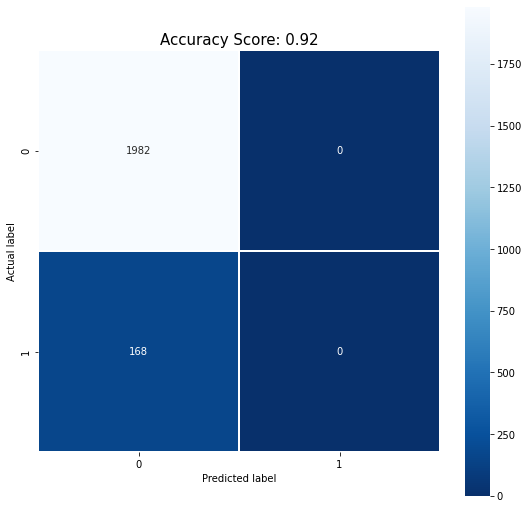

In [10]:
cm = metrics.confusion_matrix(y_test, yhat)
plt.figure(figsize=(9,9))
score = (logreg_scaled.score(X_test_scaled, y_test))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score, 2))
plt.title(all_sample_title, size = 15);

## Testing Data - Random Forest  ##

In [11]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=200)
rforest.fit(X_train_scaled,y_train)
ypred = rforest.predict(X_test_scaled)

In [12]:
print("RANDOM FORESST (SCALED DATA)")
print("Training set score: {:.2f}".format(rforest.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(rforest.score(X_test_scaled, y_test)))

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(rforest, 
                                                                             X_train_scaled, 
                                                                             y_train, 
                                                                             cv=skfold,
                                                                            scoring = 'accuracy'))))

rforest_feature = pd.DataFrame(data=rforest.feature_importances_).T
rforest_feature.columns = X.columns
rforest_feature.index=['Random Forest Features']


rforest_feature.T.sort_values(by = 'Random Forest Features', ascending=False)

RANDOM FORESST (SCALED DATA)
Training set score: 0.94
Test set score: 0.90
Mean Cross Validation, SKFold: 0.90


,Random Forest Features
skillspeaking,0.149916
skillwriting,0.139967
skillsocialper,0.138167
female,0.098121
extracurricular_skills,0.093338
ba_quality,0.092520
exp_highquality,0.088926
ma,0.063204
language_skills,0.062248
accreditation,0.036793


<AxesSubplot:title={'center':'Feature Importance (Random Forest)'}>

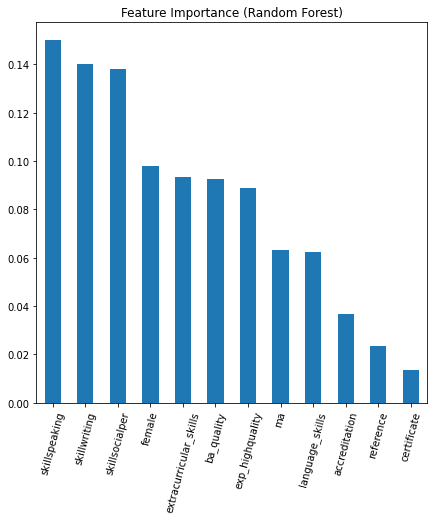

In [13]:
rf_graph = rforest_feature.T.sort_values(by = 'Random Forest Features', ascending=False)
rf_graph['Random Forest Features'].plot.bar(
    title = 'Feature Importance (Random Forest)',
    legend = False, 
    figsize = (7,7),
    rot = 75)

In [14]:
print(metrics.classification_report(ypred, y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      2100
         1.0       0.04      0.12      0.06        50

    accuracy                           0.90      2150
   macro avg       0.51      0.52      0.50      2150
weighted avg       0.96      0.90      0.93      2150



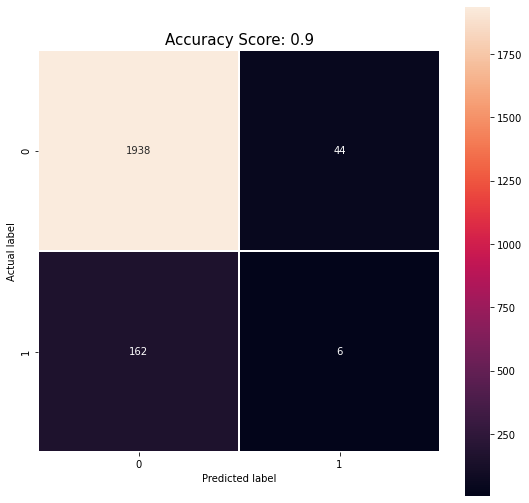

In [15]:
rf_mat = metrics.confusion_matrix(y_test, ypred)
plt.figure(figsize=(9,9))
score = (rforest.score(X_test_scaled, y_test))
sns.heatmap(rf_mat, annot=True, fmt=".0f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score, 2))
plt.title(all_sample_title, size = 15);